## 사전계획 몇가지

(1) LMS 에서는 데이터 전처리 전에 가격을 분리한다. 하지만 가격과의 상관관계 등을 분석해보기 위해서 데이터 관찰 및 전처리 후에 해당 작업을 진행할 것이다.  
(2) LMS 에서는 학습데이터와 테스트 데이터를 합쳐서 데이터를 관찰한다. 하지만 나는 둘을 따로따로 관찰해 볼 예정이다.  
(3) 모든 데이터들을 자세하게 살펴 볼 계획이다.

이번에 집중하려고 했던 부분은 데이터의 전처리 부분이다. 사실 익스1부터 계속 느끼고 있는 부분이지만 데이터 전처리의 수준에 따라서 결과가 꽤 많이 달라진다. 이번에는 데이터를 가공하는 기법 중 하나인 FE(Feature Engineerning)을 사용하려고 한다. FE는 그대로 사용하기에는 어려운 데이터의 변수를 가공하여 데이터를 비교적 간단명료하게 만드는 작업이다.

## Import Module

In [139]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import scipy as sp

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

## 2. 데이터 로딩 및 1차 확인작업

In [140]:
data_dir = os.getenv('HOME') + '/aiffel/workplace/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train_len = len(train)
test_len = len(test)

print('데이터 로딩 완료!!')

데이터 로딩 완료!!


In [141]:
train_len = len(train)
test_len = len(test)

print(train_len)
print(test_len)

15035
6468


## 2-1. 데이터 1차 확인

In [7]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2-2. 컬럼의 값들 확인

In [13]:
cols = train.columns
cols

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

각 컬럼 값들을 다음과 같은 의미를 가지고 있다.  
데이터 전처리시에 참고하도록 하자

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

## 3. 데이터 탐색 및 전처리

## 3-1. 결측값 확인 / train date set / matrix()

<AxesSubplot:>

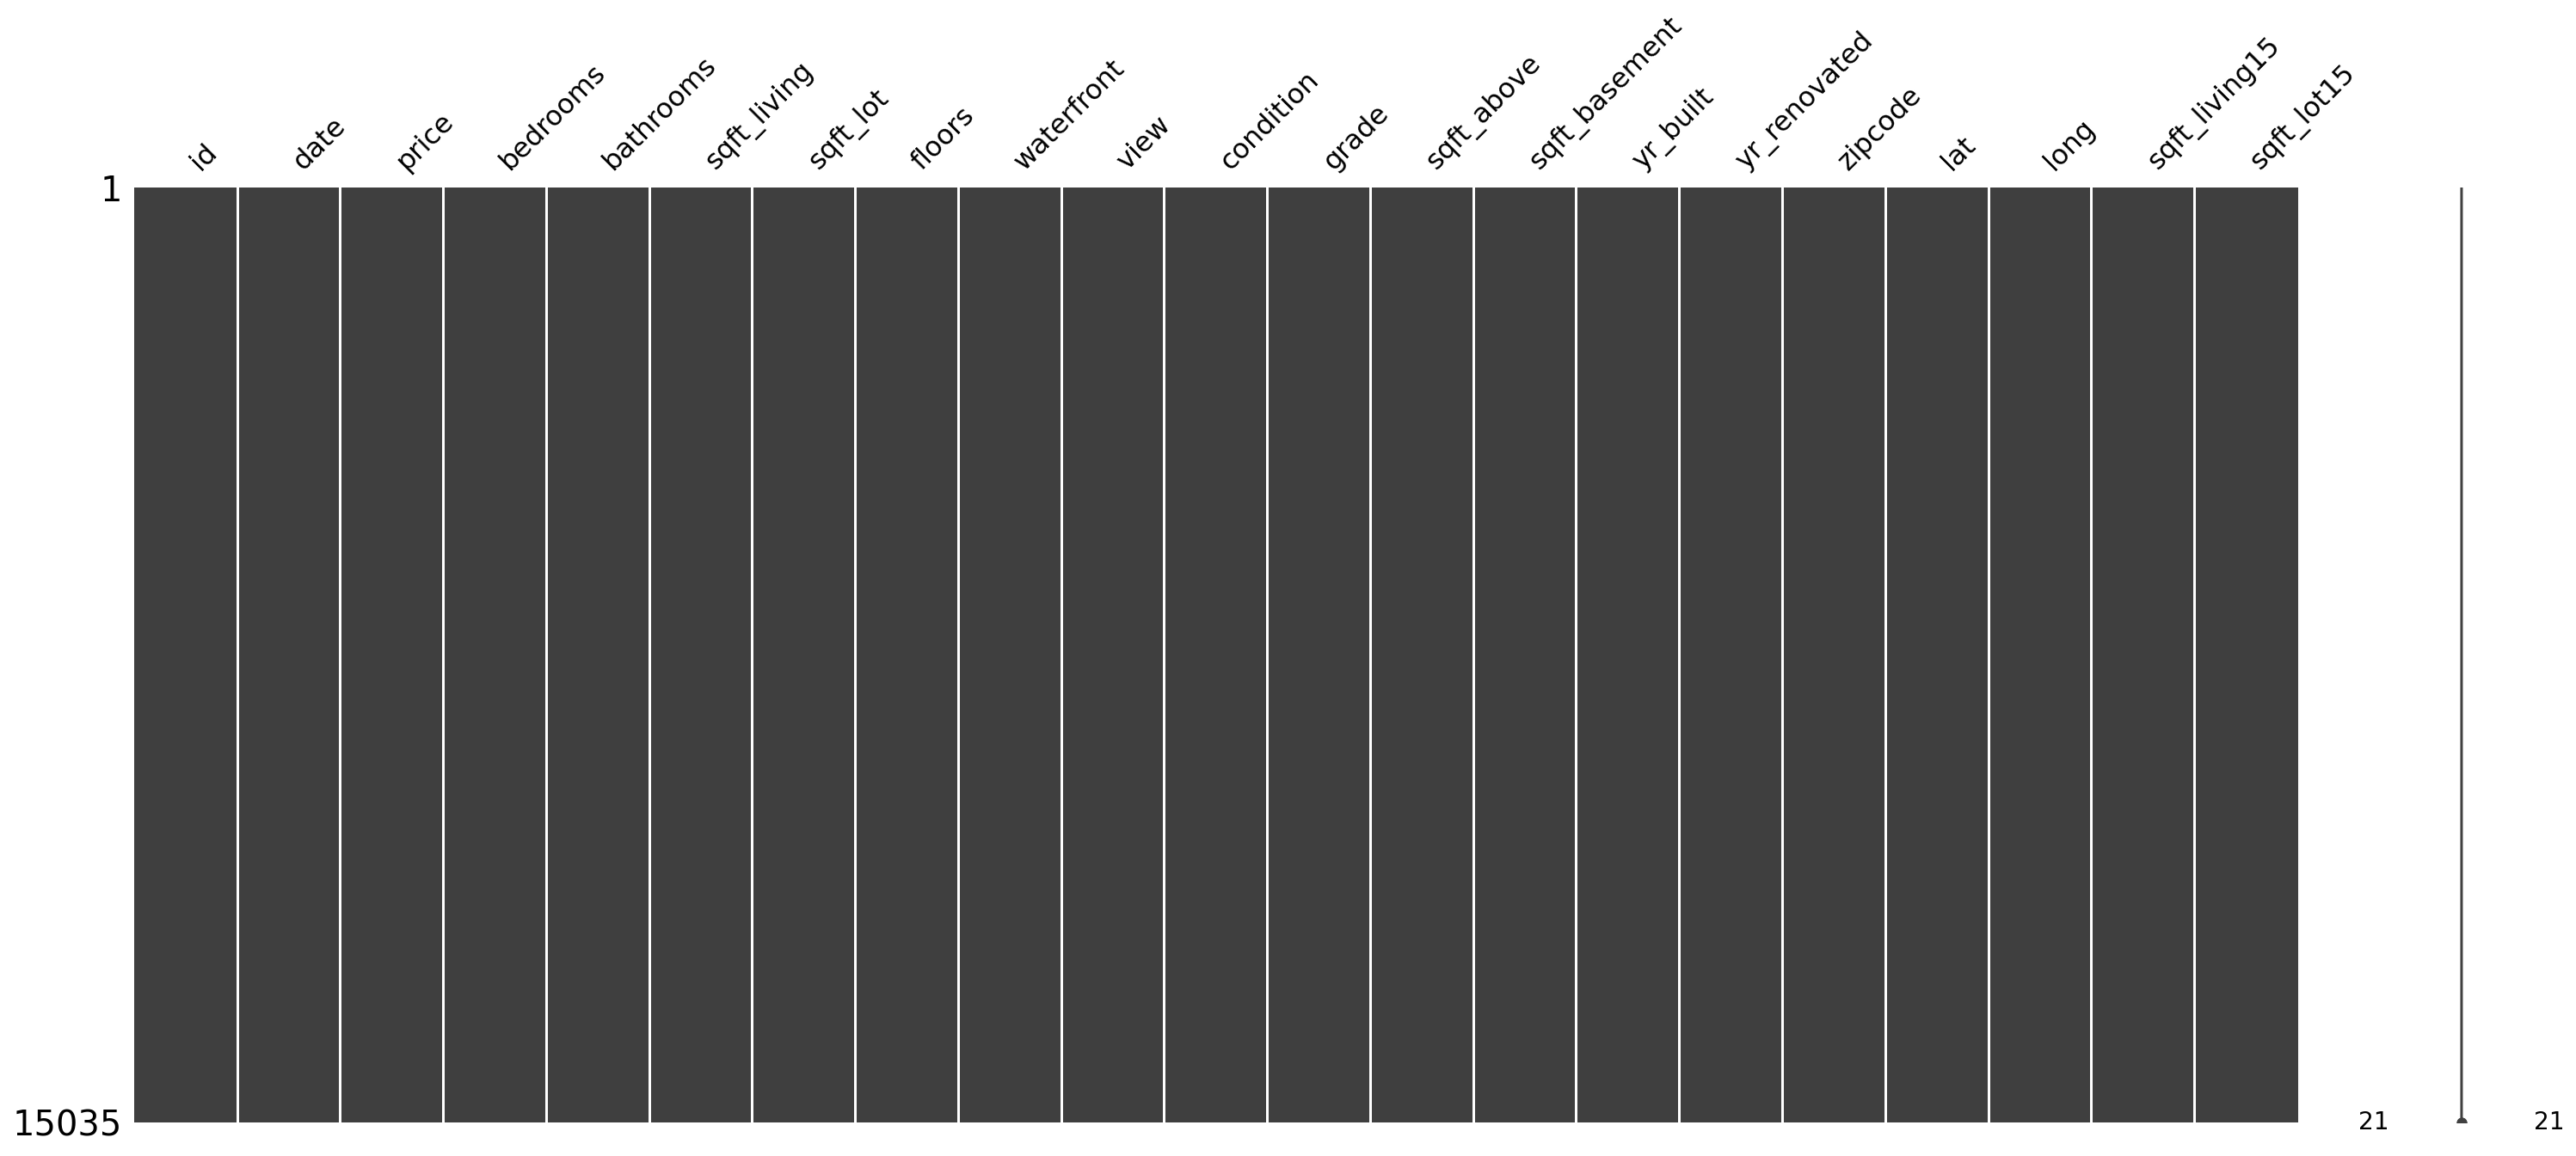

In [12]:
# LMS 에서 사용한 방법을 사용해서 결측치를 확인해 보자
msno.matrix(train)

## 3-2. 결측값 확인 / test data / matrix()

<AxesSubplot:>

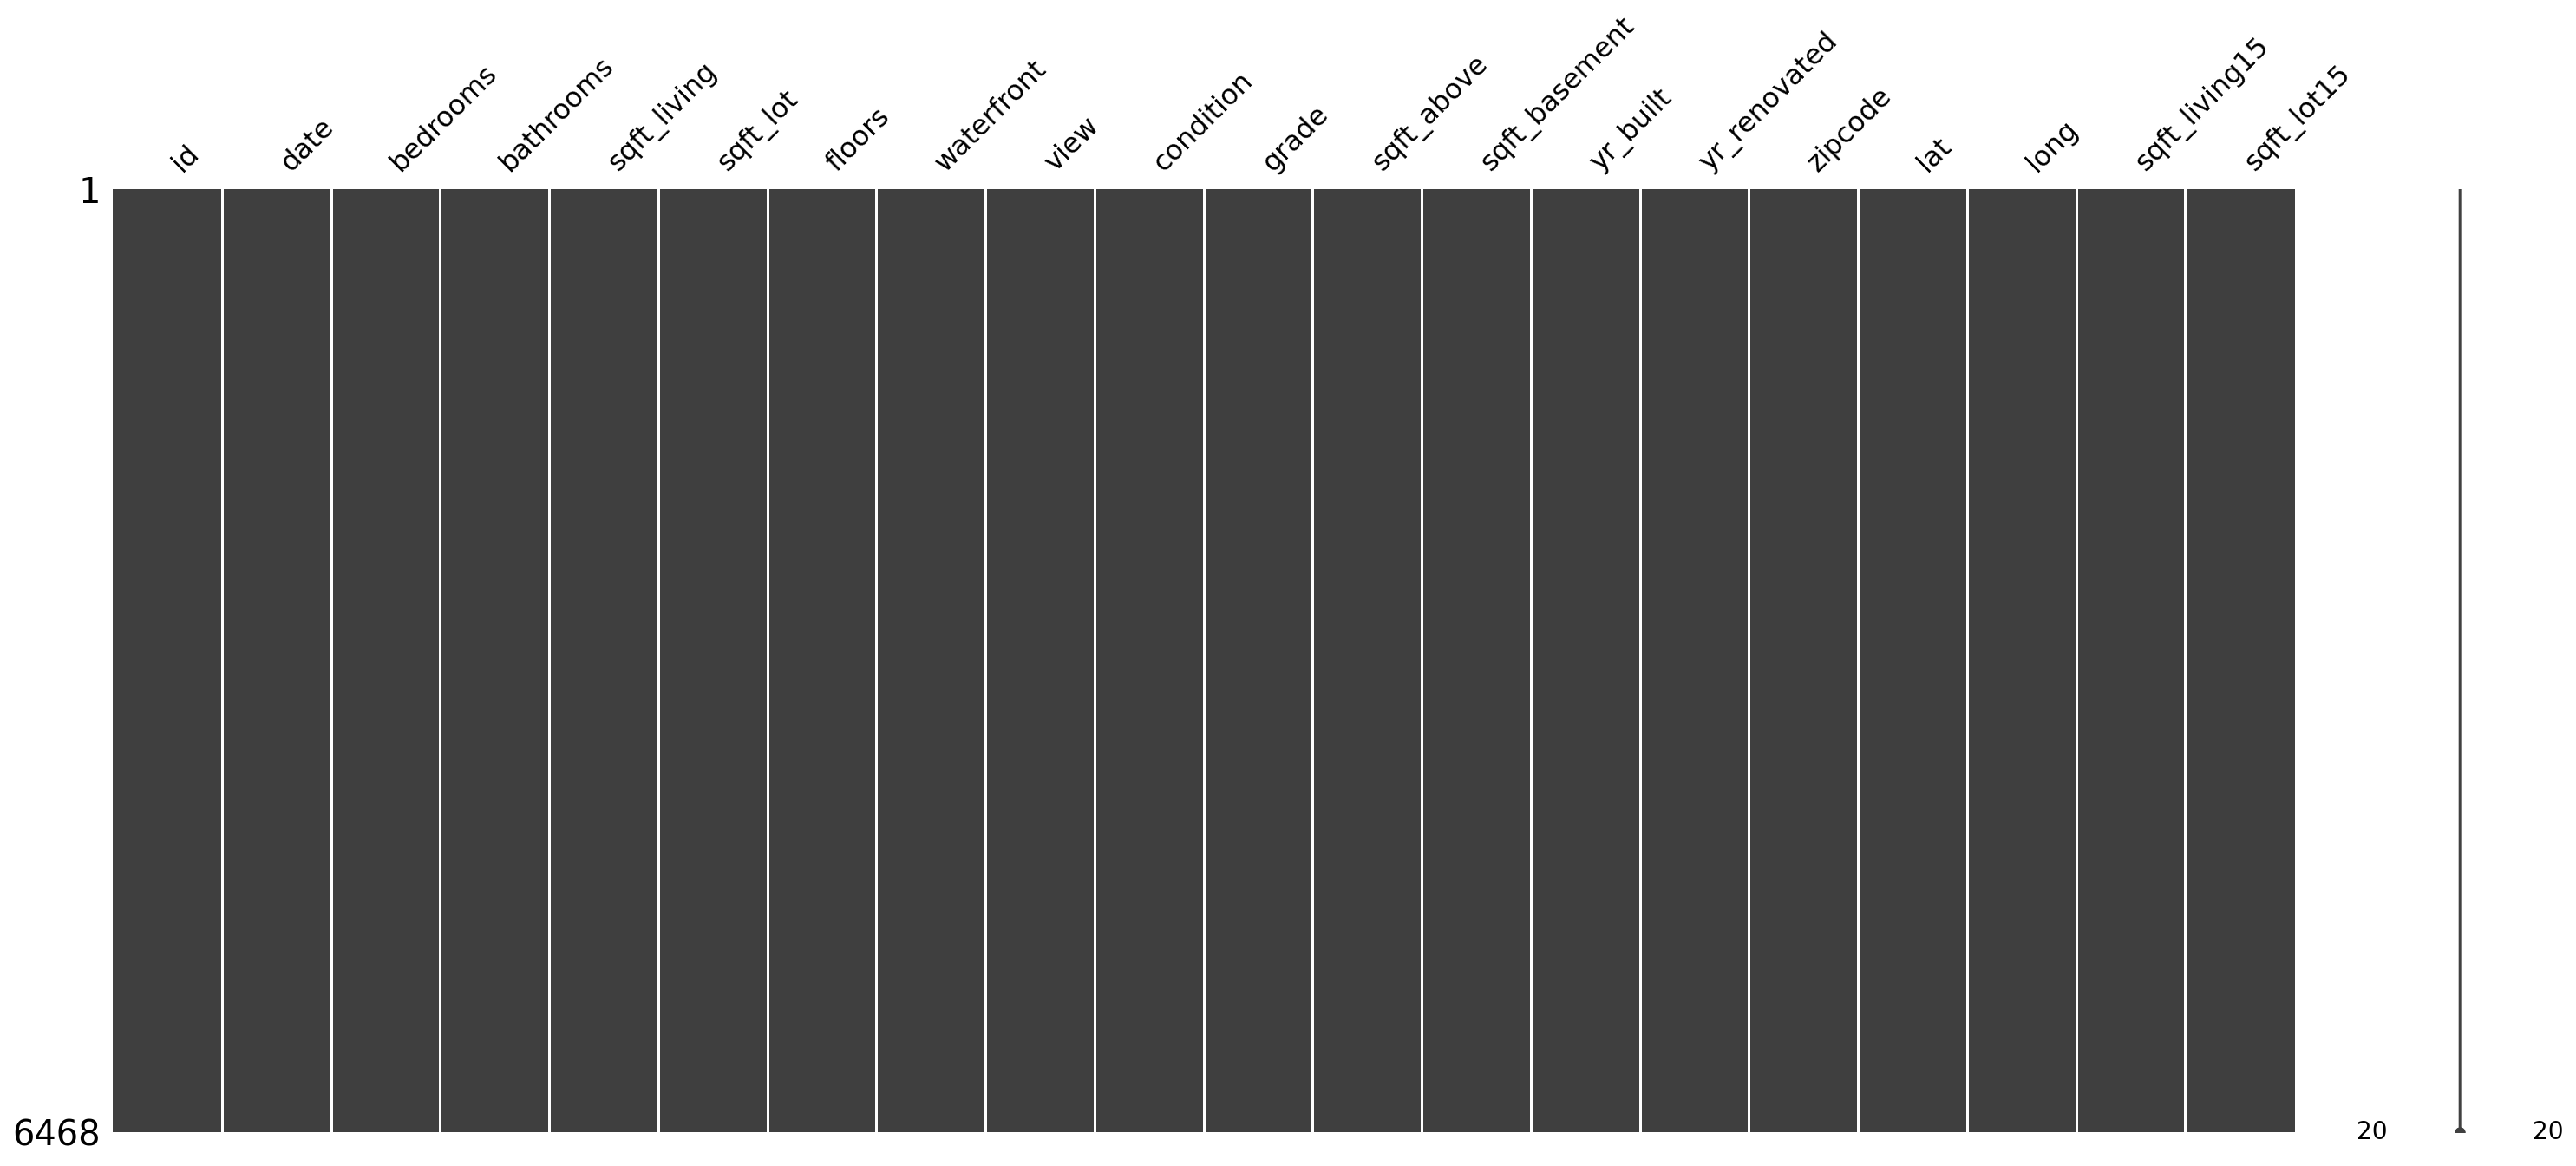

In [11]:
# LMS 에서 사용한 방법을 사용해서 결측치를 확인해 보자
msno.matrix(test)

## 3-3. 결측값 확인 / train date / isnull()

In [14]:
# isnull()을 사용해서 결측치를 확인해 보자
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 3-4. 결측값 확인 / test date / isnull()

In [15]:
# isnull()을 사용해서 결측치를 확인해 보자
test.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 3-5. 결측치 분석결과

train, test set에서 결측치 확인결과 결측치는 존재 하지 않는 것으로 확인되었기 때문에  
결측치 전처리는 진행하지 않아도 된다.

## 4. 중복 데이터 확인
중복데이터 확인결과 존재 하는 것으로 확인됨 해당 행을 삭제

In [142]:
print(len(train['id']))
print(len(pd.value_counts(train['id'])))

15035
15035


## 5. 가격분포 확인

<AxesSubplot:xlabel='price', ylabel='Density'>

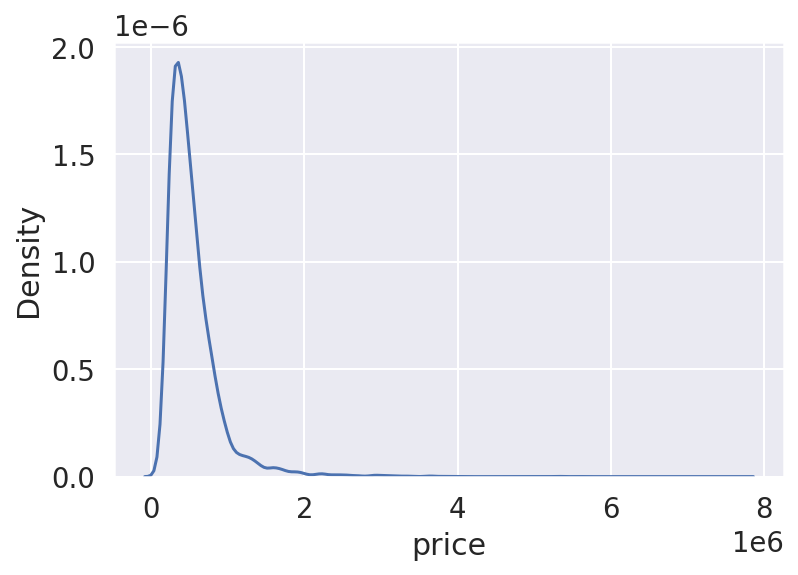

In [143]:
fig = plt.subplots(figsize=(6,4))
sns.kdeplot(train['price'])
#sns.distplot(train['price'])


# 아래 코드는 두개의 그래프에 동시에 디스플레이 할 경우 사용하는 코드이다. 
# 원래 test 데이터와 함께 디스플레이 하려고 했으나 test 데이터는 원래 부터 가격항목이 없어서 불가능

#fig, ax = plt.subplots(figsize=(6,4), ncols=2)

#sns.distplot(train['price'], ax=ax[0])
#sns.distplot(test['price'], ax=ax[1])

첫번째 단계로 train data의 가격 분포를 확인한 결과 왼쪽으로 매우 바이어스 된 것을 확인했다.  
두번째 단계로 가격을 기준으로, stats.probplot() 매서드를 사용해서 분포를 확인해보면  
선형적으로 나오지 않는다. 해당 데이터를 선형적으로 만들어 주도록 하자.

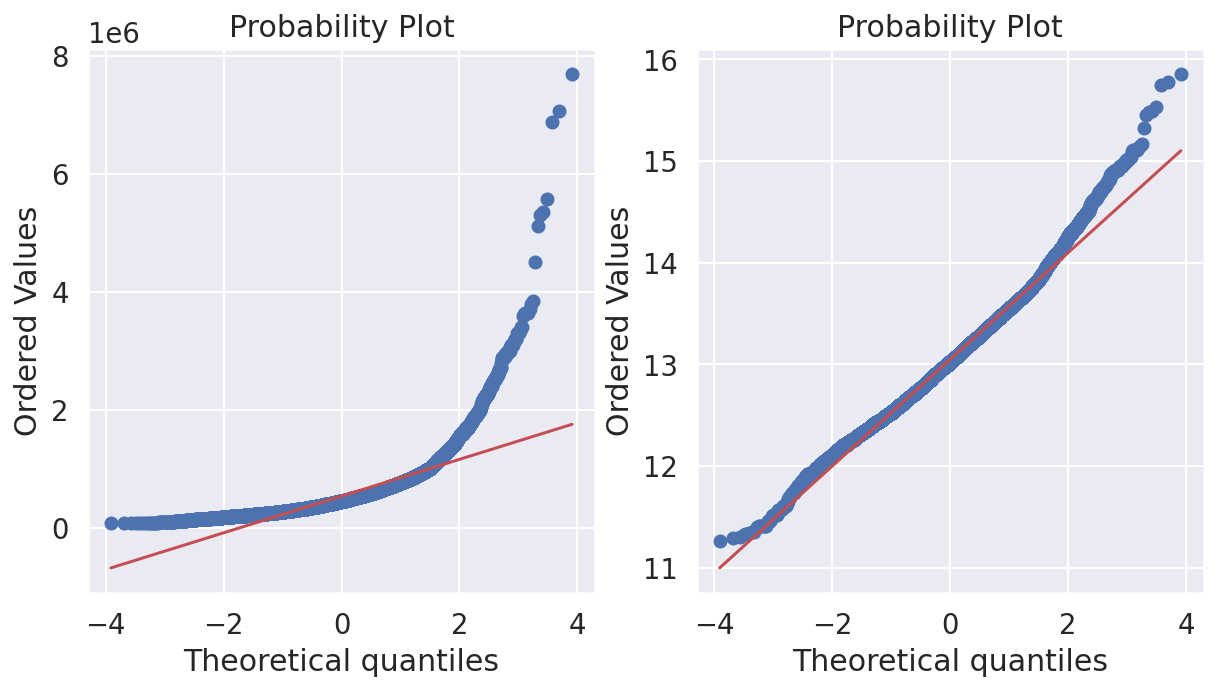

In [144]:
fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)
res = sp.stats.probplot(train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = sp.stats.probplot(np.log1p(train['price']), plot=plt)

log scale로 변환하여 선형성을 확보했다.

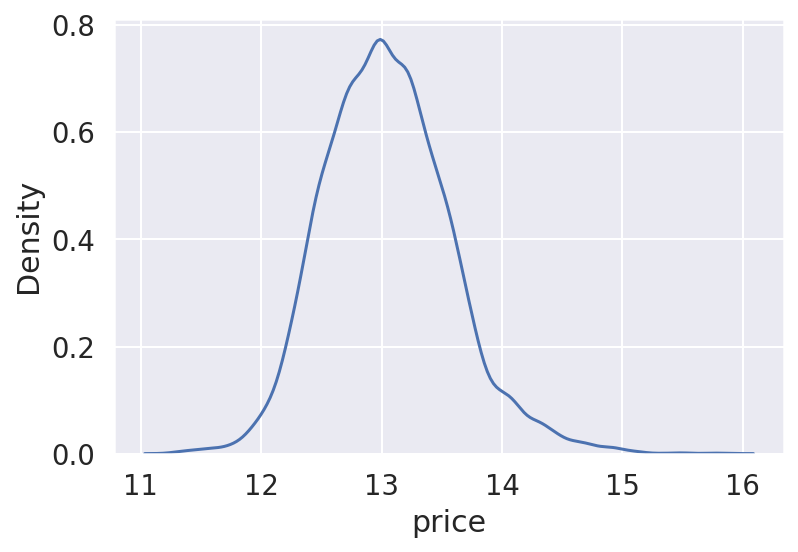

In [145]:
# np.log1p(y) : 로그함수로 변환
#np.expm1(y) : 각 원소x마다 exp(x)-1을 반환

train['price'] = np.log1p(train['price'])
sns.kdeplot(train['price'])
#sns.distplot(train['price'])
plt.show()

## 6. 변수별 상관관계 확인

spearman 상관계수를 사용하여 순위상관을 히트맵으로 나타냈다.  
spearman 상관계수는 순위상관으로 범주형 변수가 포함되어 있을 때, 목적변수와 가장 상관관계가 높은 순서대로 정렬해주는 식이다. 

결과를 보면 price와 상관관계가 있는 변수들은 다음과 같은 순서로 나타났다. (좌측이 가장 높다.)  
'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms' 'lat' 'bedrooms' 'floors' 'view'

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

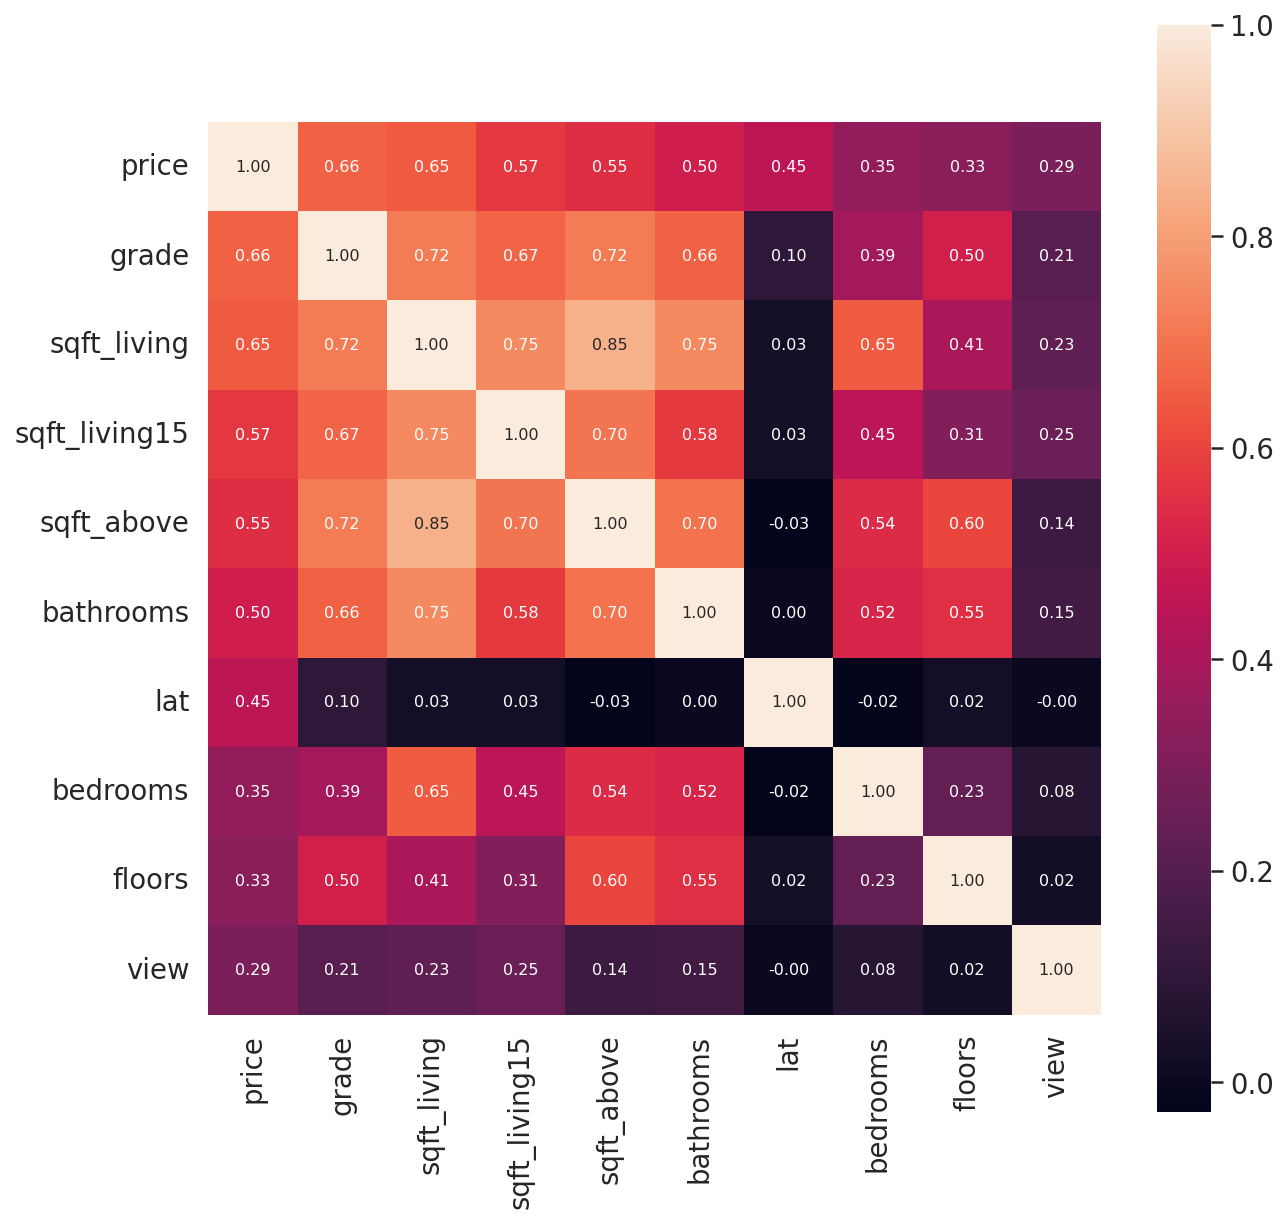

In [146]:
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

## 7. 이상치 확인 및 조치

## 7-1. 이상치 확인 / grade

### 결과: 이상치 존재하여 해당항목 삭제

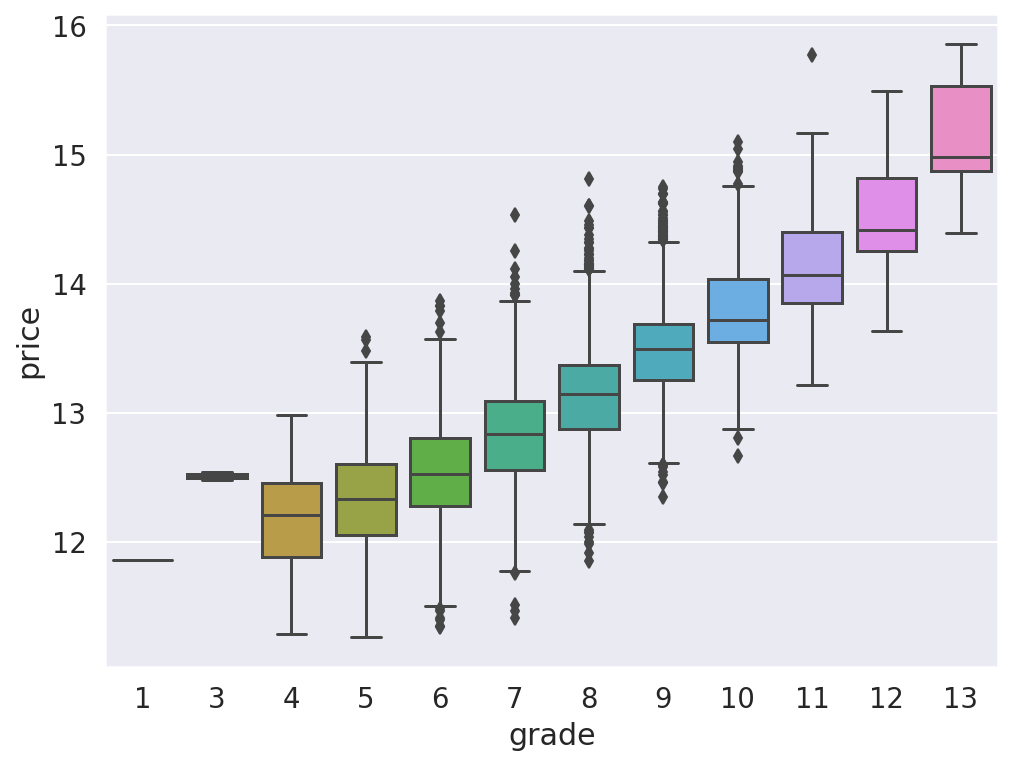

In [147]:
# 이상치를 제거 하자
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data = data)

In [148]:
train.loc[(train['grade'] == 3) & (train['price'] > 12)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [149]:
train.loc[(train['grade'] == 7) & (train['price'] > 14.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [150]:
train.loc[(train['grade'] == 8) & (train['price'] > 14.7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [151]:
train.loc[(train['grade'] == 11) & (train['price'] > 15.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


- 확인된 grade 이상치를 제거

In [152]:
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 12346]
train = train.loc[train['id'] != 7173]
train = train.loc[train['id'] != 2775]
print(len(train['id']))

15030


## 7-2. 이상치 확인 / sqft_living

### 결과: 이상치 존재하여 해당항목 삭제

- sqft_living : 주거 공간의 평방 피트(면적)
- 전체적으로 크기가 커지면 가격이 오르는 것을 볼 수 있다.

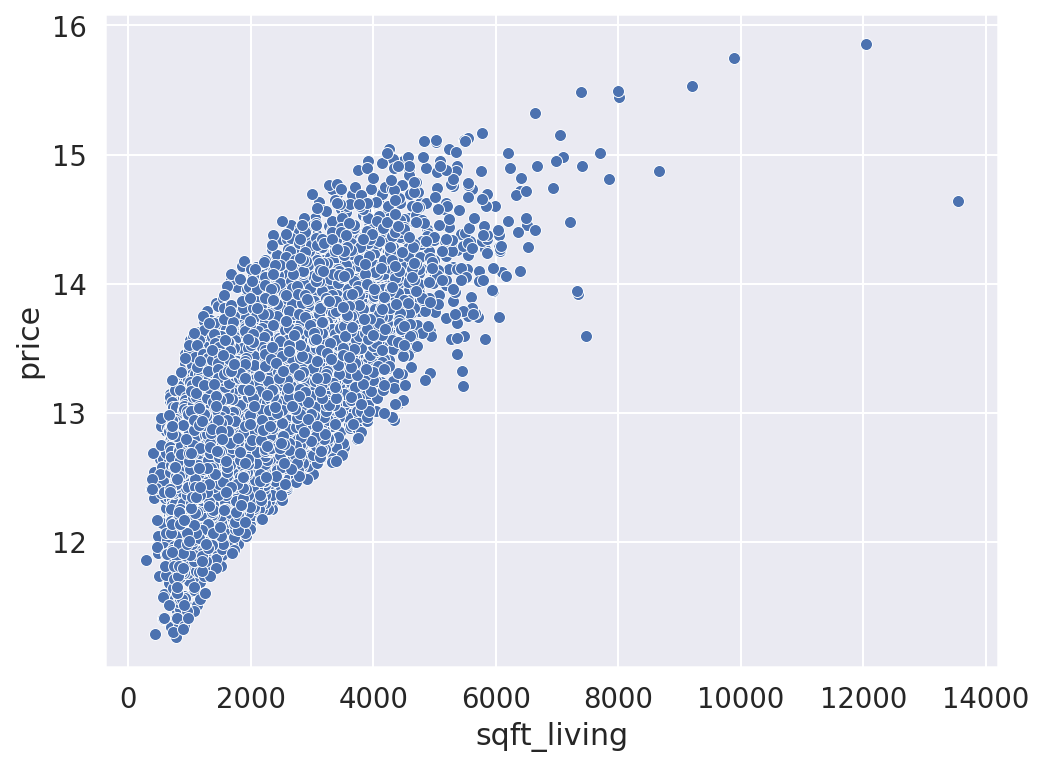

In [153]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='sqft_living', y='price', data = data)

- 4000일때 가격이 비교적 아래에 있는 것을 보아 이상치로 판단 했다

In [154]:
train.loc[train['sqft_living']>13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


- sqft_living이 7000 이상에서 가격이 14 아래로 형성되는 것도 이상치로 판단했으나 최종 판단에서는 보류했다.

In [155]:
train.loc[(train['sqft_living']>7000) & (train['price'] < 14)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1941,1941,20140730T000000,13.919871,5,3.50,7350,12231,2.0,0,4,...,11,4750,2600,2001,0,98065,47.5373,-121.865,5380,12587
2859,2859,20141007T000000,13.592368,7,6.75,7480,41664,2.0,0,2,...,11,5080,2400,1953,0,98166,47.4643,-122.368,2810,33190
12921,12921,20140708T000000,13.942364,5,4.00,7320,217800,2.0,0,0,...,11,7320,0,1992,0,98058,47.4473,-122.086,3270,34500


- sqft_living 이상치를 제거

In [156]:
train = train.loc[train['id'] != 8912]
print(len(train['id']))

15029


## 7-2. 이상치 확인 / sqft_above

### 이상치 없음

- sqft_above : 지하실을 제외한 평방 피트(면적)

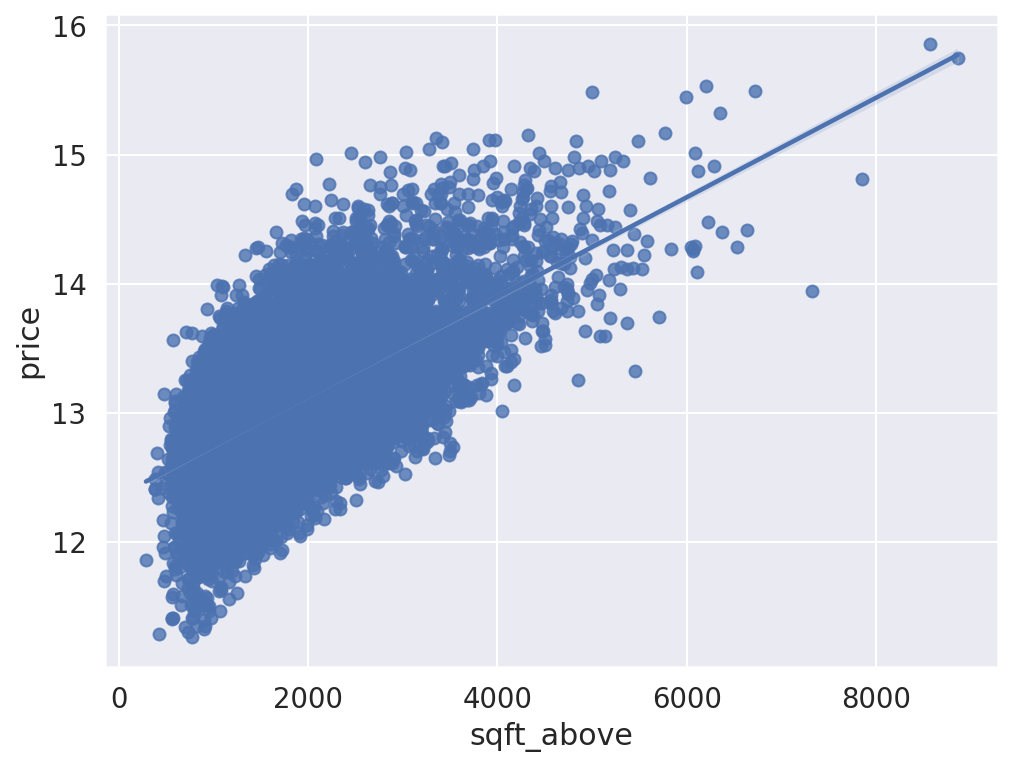

In [36]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y='price', data = data)

## 7-3. 이상치 확인 / bathrooms

### 이상치 없음

- bathrooms : 화장실의 수
- 0.5 : 세면대, 화장실
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조

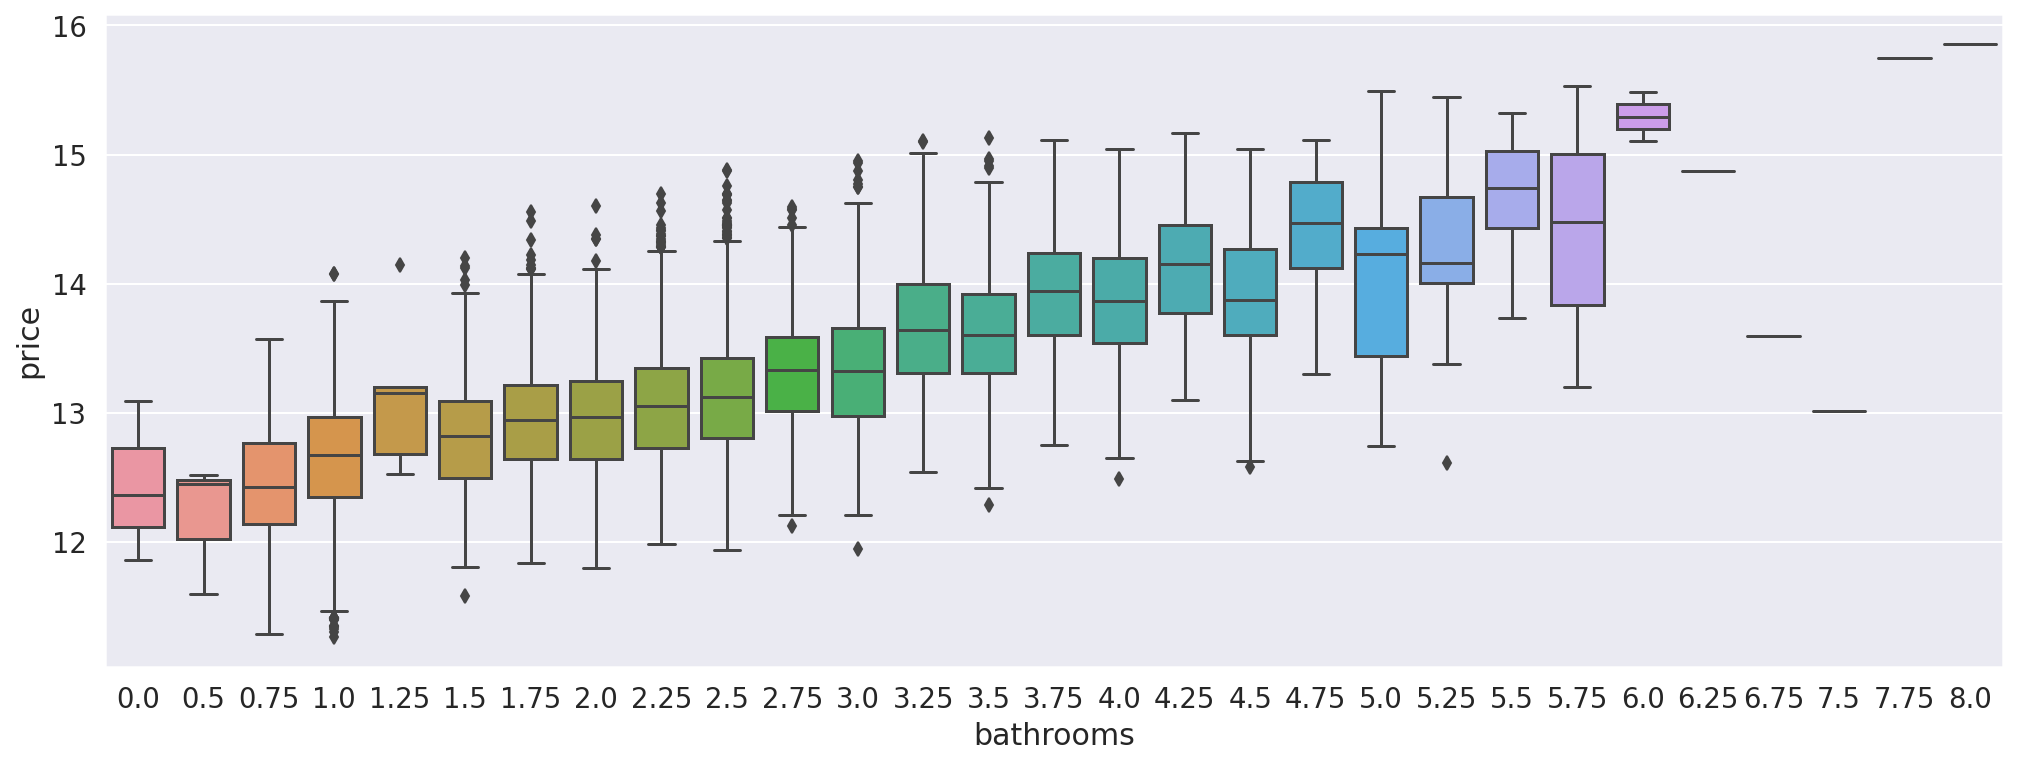

In [37]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(17, 6))
fig = sns.boxplot(x='bathrooms', y='price', data = data)

## 7-4. 이상치 확인 / lat(위도)

### 이상치 없음

47.5도 부터 집값이 높아지기 시작해서 47.6부근에서 가장 높게 나타난다.

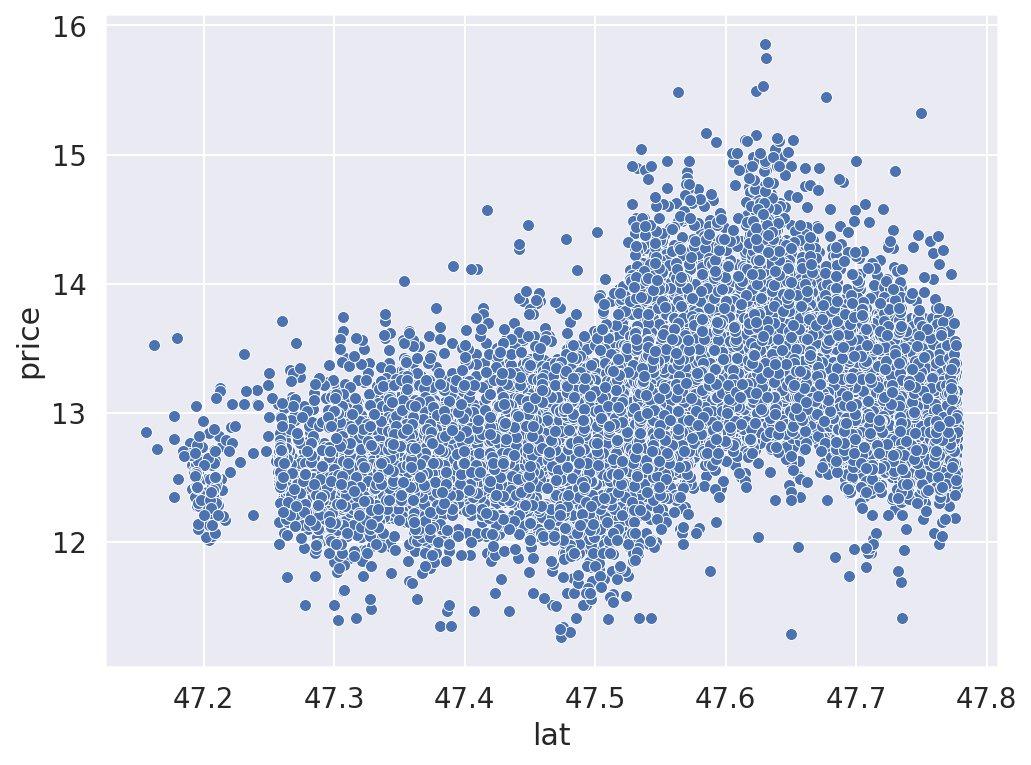

In [38]:
data = pd.concat([train['price'], train['lat']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='lat', y='price', data = data)

## 8. 날짜 형태 변환

In [157]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

## 9. id 삭제

### id는 분석에 의미가 없으므로 삭제.

In [158]:
# 결측치 및 이상치 수정으로 인해 변경된 최종 데이터 형태로 저장한다.
train_len = len(train)
test_len = len(test)

sub_id_train = train['id'][train_len:]
del train['id']

sub_id_test = test['id'][test_len:]
del test['id']

print(train.columns)
print(test.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 10. 정규화

### 각 데이터를 확인하고 정규화가 필요하다고 판단되는 데이터는 정규화를 진행한다.

## 10-1. 데이터 확인

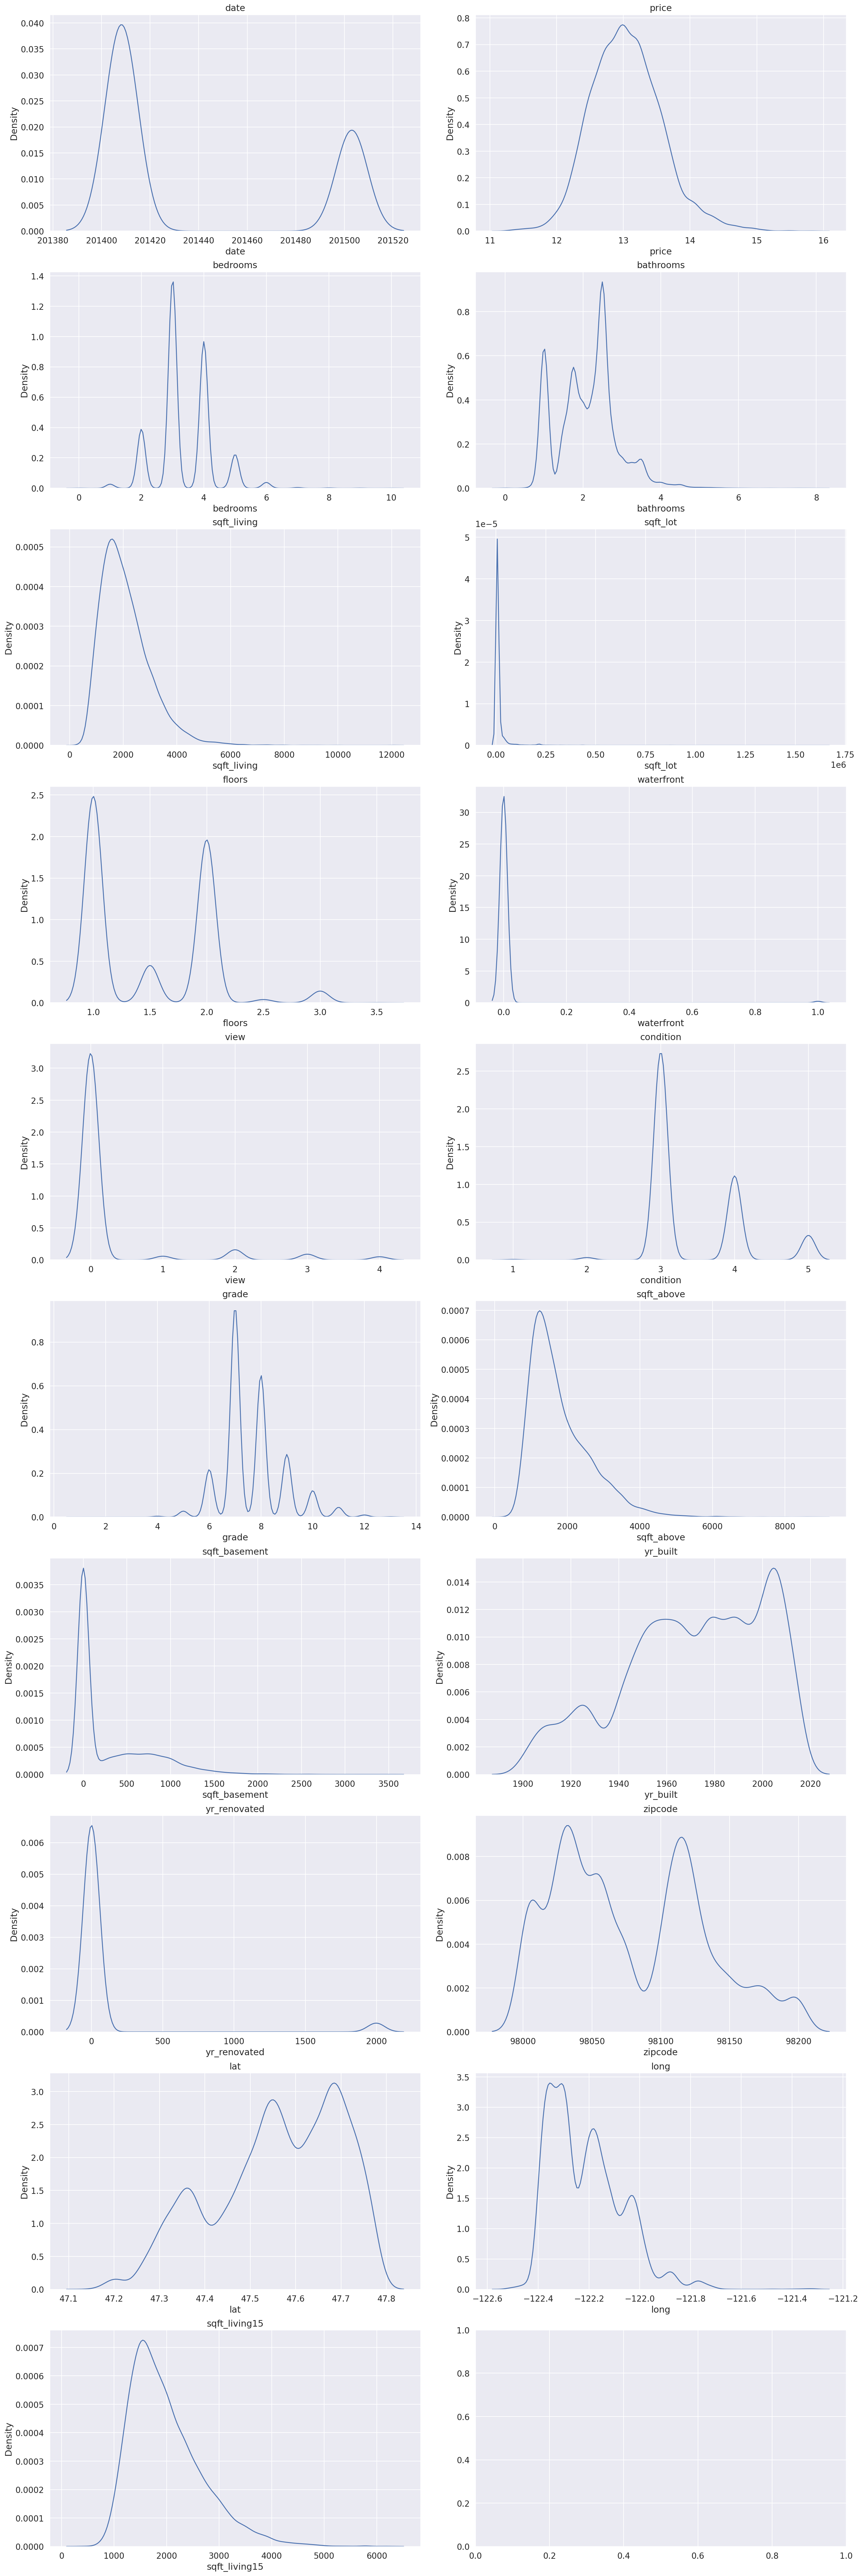

In [159]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60), constrained_layout=True)
columns = train.columns
count = 0
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

## 10-2. 정규화 진행

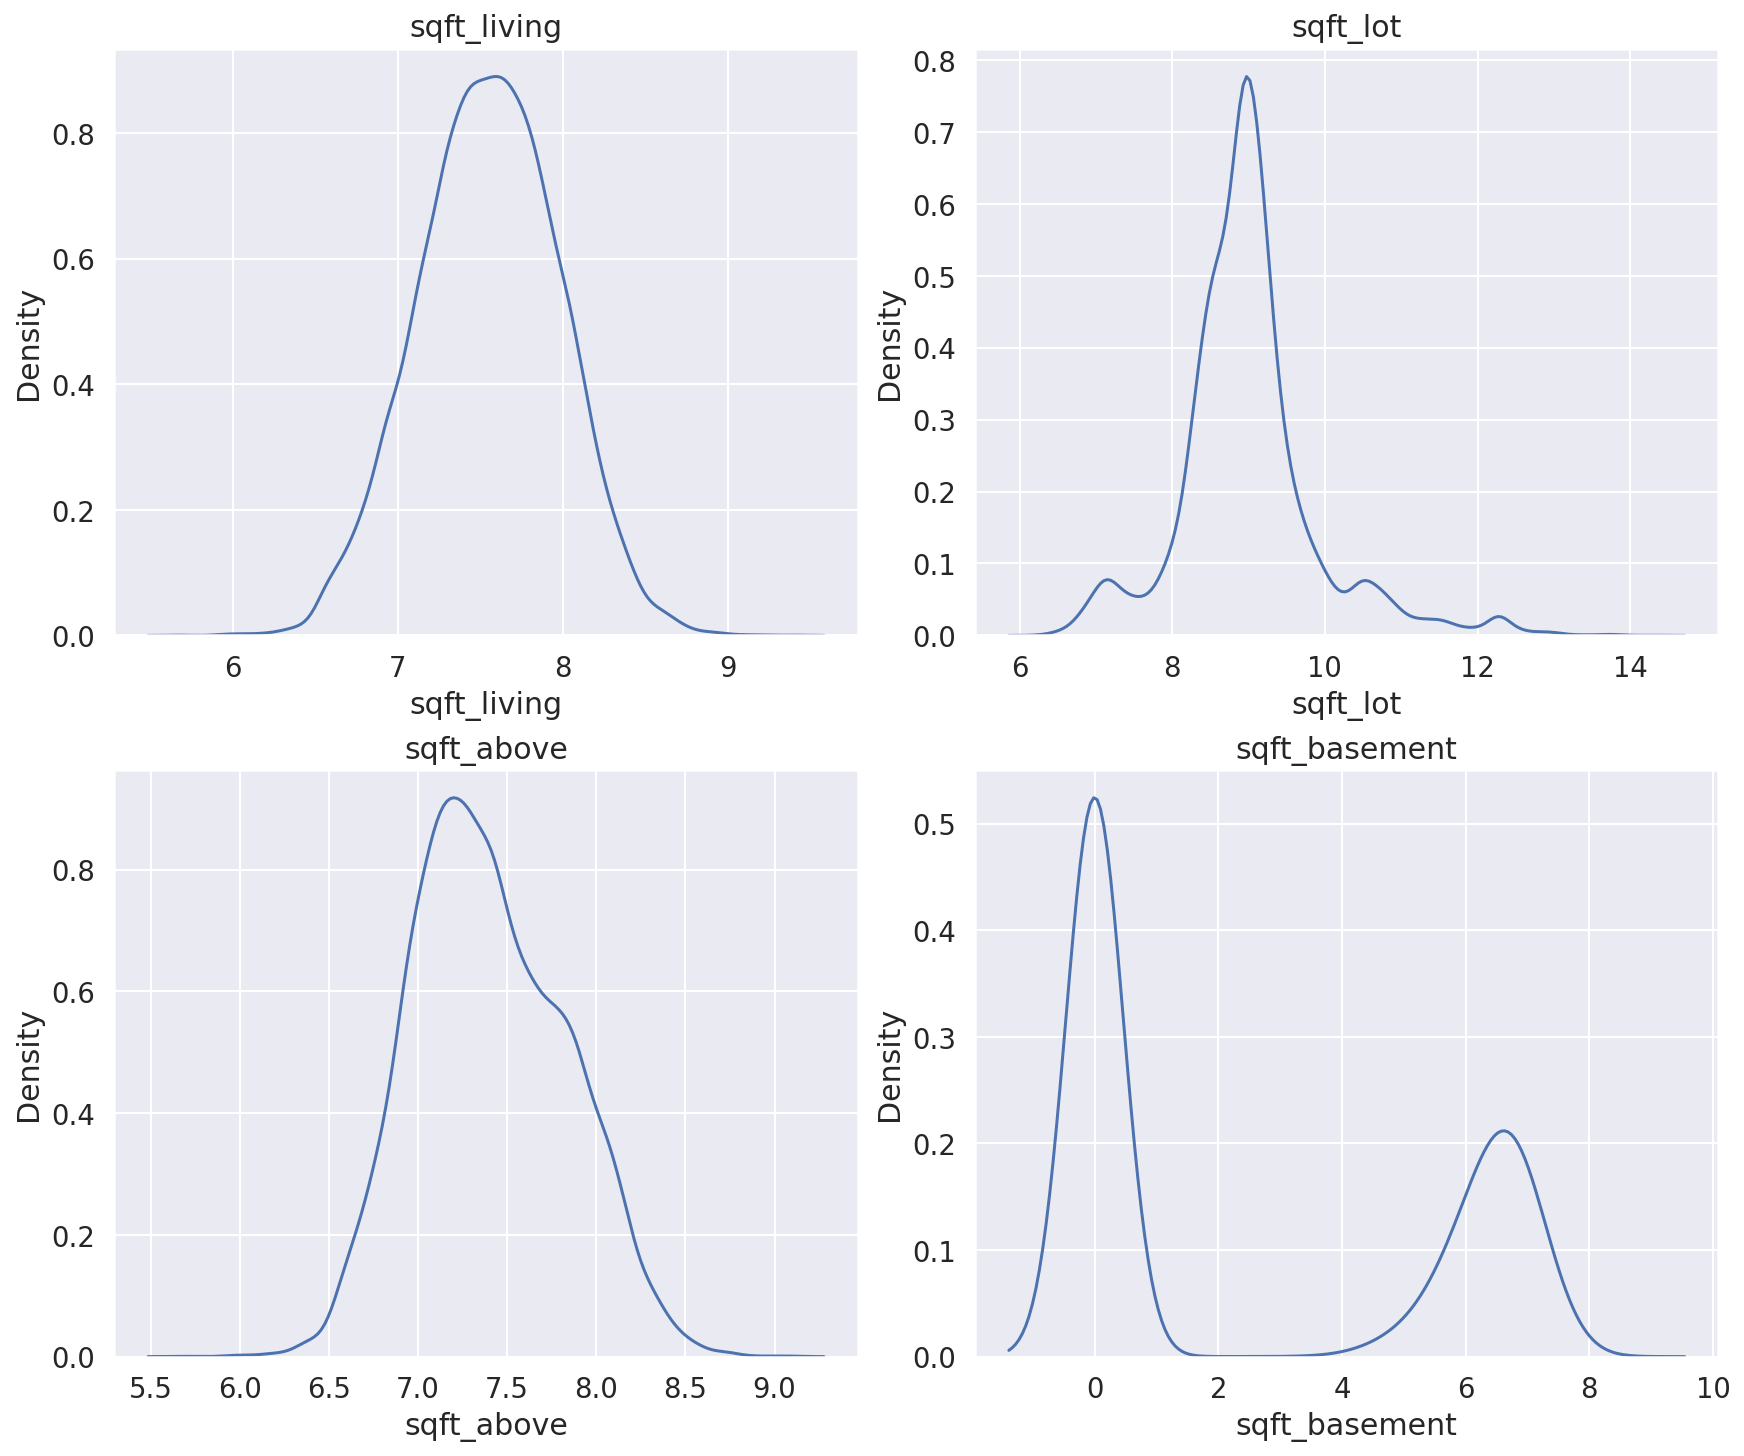

In [160]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

fig, ax = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

count = 0
for row in range(2):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

## 11. train data의 price컬럼 분리

In [161]:
y = train['price']
del train['price']

## 12. 변수형 확인

모두 실수 or 정수형인지 확인을 진행한다.  
만약 모두 실수 또는 정수형이라면 모델 학습 활용이 가능하다고 판단한다.

In [162]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15029 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15029 non-null  int64  
 1   bedrooms       15029 non-null  int64  
 2   bathrooms      15029 non-null  float64
 3   sqft_living    15029 non-null  float64
 4   sqft_lot       15029 non-null  float64
 5   floors         15029 non-null  float64
 6   waterfront     15029 non-null  int64  
 7   view           15029 non-null  int64  
 8   condition      15029 non-null  int64  
 9   grade          15029 non-null  int64  
 10  sqft_above     15029 non-null  float64
 11  sqft_basement  15029 non-null  float64
 12  yr_built       15029 non-null  int64  
 13  yr_renovated   15029 non-null  int64  
 14  zipcode        15029 non-null  int64  
 15  lat            15029 non-null  float64
 16  long           15029 non-null  float64
 17  sqft_living15  15029 non-null  int64  
 18  sqft_l

## 13. 하이퍼파라미터 튜닝

## 13-1. 그리드 탐색

GridSearchCV 사용 (Grid Search)

- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

### RMSE 계산 함수

기존에 y를 로그함수로 변환해주었기 때문에 mean_squared_error에 값을 넘기기 전,  
np.expm1으로 다시 변환해서 넘겨준다.

In [163]:
# 로그로 변환되었던 값을 다시 원상 복구 시킨다.
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 스코어 계산 함수

In [164]:
def get_scores(models, train, y):
        df = {}

        for model in models:
            model_name = model.__class__.__name__
            X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if model_name in df:
                model_name = model_name + str(models.index(model))
            df[model_name] = rmse(y_test, y_pred)
            score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
        return (score_df)

### 그리드 탐색함수

In [165]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                            scoring='neg_root_mean_squared_error',
                            cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    grid_model.cv_results_

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = -1 * results['score']
    results = results.sort_values(['RMSLE'])

    return results

### save_submission 함수 선언

In [166]:
def save_submission(model, train, y, test, model_name, rmsle):
    # 위에 나온 결과로 학습 및 예측 결과 생성
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)  # 원래 스케일로 되돌림
    data_dir = os.getenv('HOME')+'/aiffel/workplace/kaggle_kakr_housing/data'
    
    # csv에 쓰기
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [167]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

### save_model 함수 선언

In [168]:
def save_model(y_pred, model_name, rmsle=None):
    data_dir = os.getenv('HOME')+'/aiffel/workplace/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    submission['price'] = np.expm1(y_pred)
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 탐색할 파라메터 준비

In [169]:
param_grid = {
    'boosting': ['goss'],
    'n_estimators': [1400, 1600, 2000],
    'max_depth': [5, 7, 9, 11,13],
    'learning_rate': [0.015, 0.018, 0.021, 0.024]
}

In [170]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   4.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   4.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1600; total time=   5.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=2000; total time=   6.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boost

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   3.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   3.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1600; total time=   3.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1600; total time=   3.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=2000;

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=9, n_estimators=2000; total time=   6.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=9, n_estimators=2000; total time=   6.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=11, n_estimators=1400; total time=   4.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=11, n_estimators=1400; total time=   4.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=11, n_estimators=16

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=11, n_estimators=1600; total time=   6.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=11, n_estimators=2000; total time=   7.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=11, n_estimators=2000; total time=   7.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=13, n_estimators=1400; total time=   5.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.018, max_depth=13, n_estimators=

,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
7,goss,0.015,9,1600,-0.159359,0.159359
6,goss,0.015,9,1400,-0.159445,0.159445
8,goss,0.015,9,2000,-0.159553,0.159553
5,goss,0.015,7,2000,-0.159748,0.159748
4,goss,0.015,7,1600,-0.159749,0.159749
21,goss,0.018,9,1400,-0.159823,0.159823
22,goss,0.018,9,1600,-0.159830,0.159830
10,goss,0.015,11,1600,-0.159838,0.159838
42,goss,0.021,13,1400,-0.159852,0.159852
13,goss,0.015,13,1600,-0.159882,0.159882


In [179]:
xgboost = XGBRegressor(learning_rate=0.015, max_depth=9, n_estimators=1600, random_state=random_state)
lightgbm0 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=9, n_estimators=1600, random_state=random_state)
lightgbm1 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=9, n_estimators=1400, random_state=random_state)
lightgbm2 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=9, n_estimators=2000, random_state=random_state)
lightgbm3 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=7, n_estimators=2000, random_state=random_state)
ereg = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm0', lightgbm0), ('lgbm1', lightgbm1), ('lgbm2', lightgbm2), ('lgbm3', lightgbm3)])

In [180]:
get_scores([xgboost, lightgbm0, lightgbm1, lightgbm2, lightgbm3, ereg], train, y)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


,RMSE
XGBRegressor,119241.513063
LGBMRegressor2,113832.734084
LGBMRegressor,113009.813746
VotingRegressor,112714.128248
LGBMRegressor3,112111.468794
LGBMRegressor4,111493.579841


In [184]:
save_submission(lightgbm3, train, y, test, "LGBMRegressor4", 111493)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
/aiffel/aiffel/workplace/kaggle_kakr_housing/data/submission_LGBMRegressor4_RMSLE_111493.csv saved!


In [183]:
save_submission(lightgbm2, train, y, test, "LGBMRegressor3", 112111)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
/aiffel/aiffel/workplace/kaggle_kakr_housing/data/submission_LGBMRegressor3_RMSLE_112111.csv saved!


# 최종 결과 109441.38754

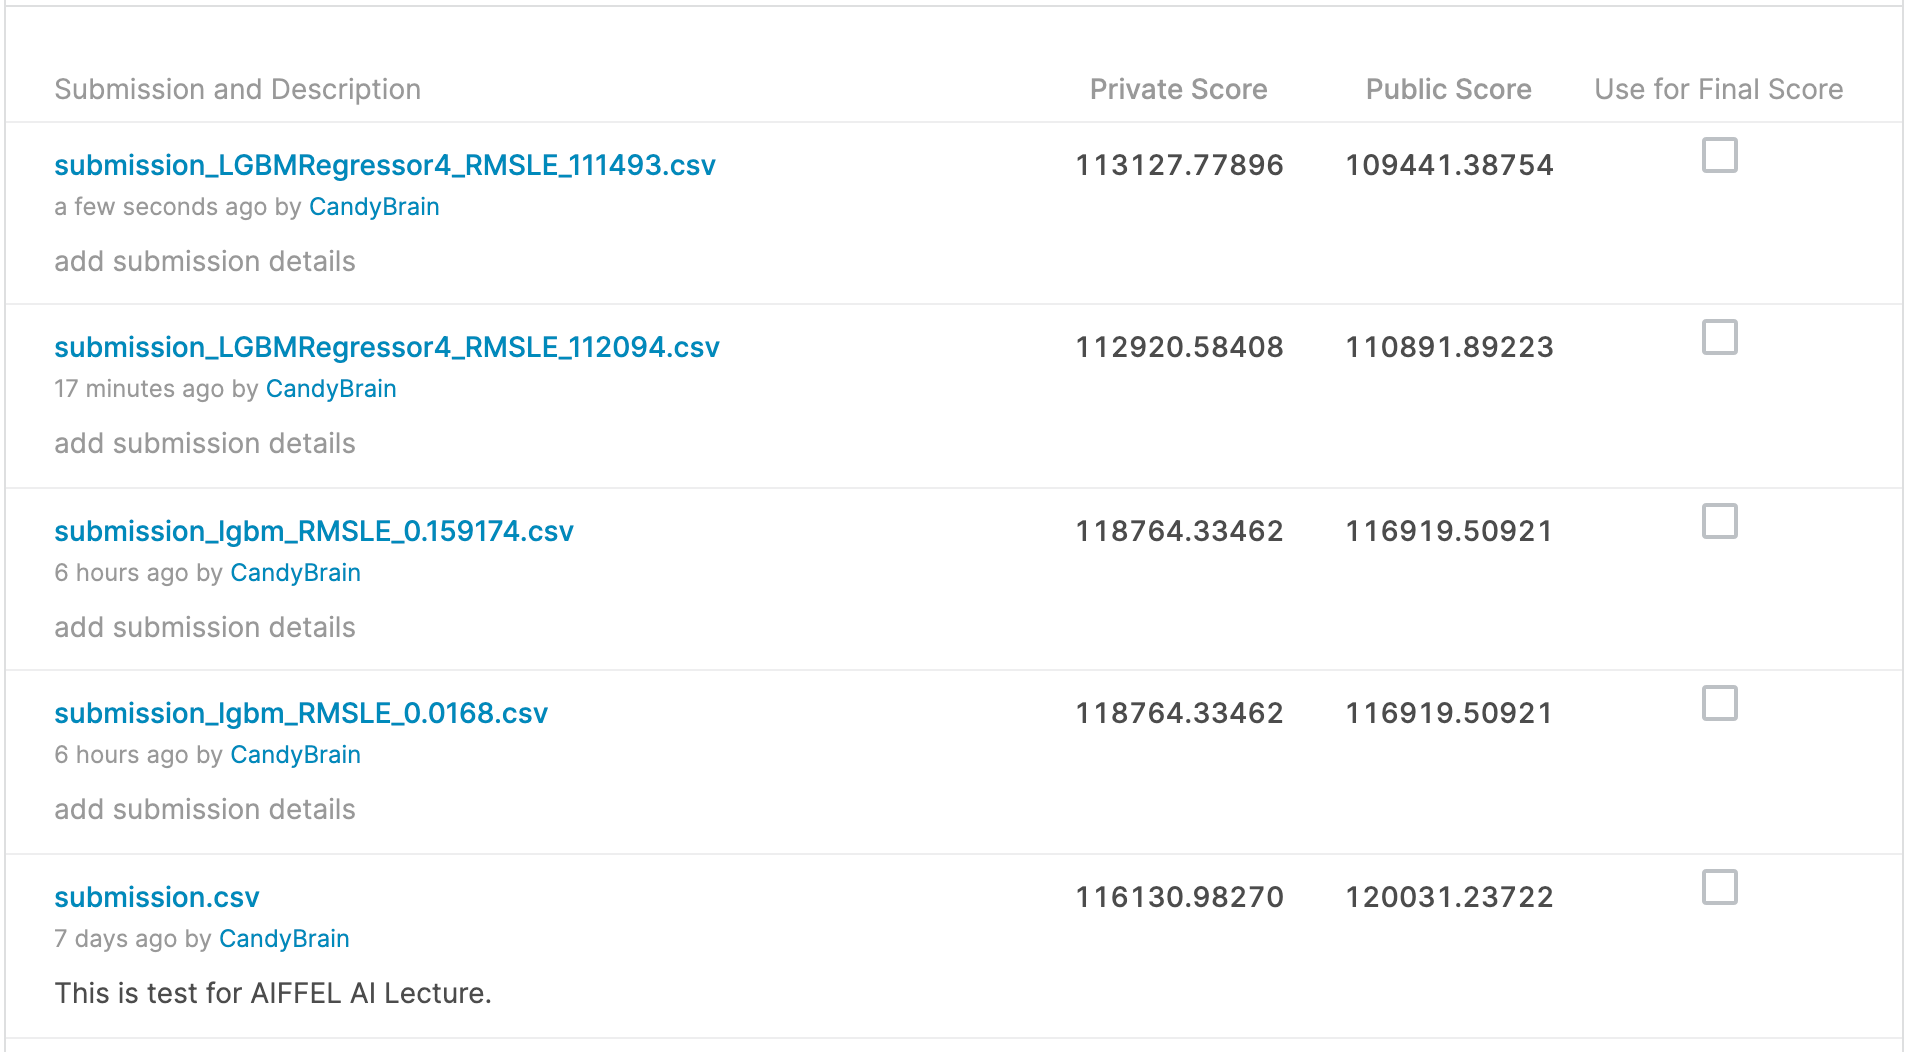

# 회고

정말 이번 익스5는 제출 마지막 날인 1월 25일 끝까지 나를 애먹이고 힘들게한 프로젝트였다.  
데이터 분석은 너무 재미 있고 관심이 있는 분야이긴 하지만 역시 고려해야 할것들이 너무 많고  
역시 처음 사용해보는 파이썬에 대한 이해도가 아직도 바닥 수준인터라 고통의 순간들을 계속 보냈다.
아무튼 하나하나 진행하면서 일단은 끝까지 왔다.

겨우겨우 110000 점 안쪽으로 들어갔네요 
밀린 익스가 너무 많아서 일단은 제출을 하고 여유가 생기면 한번 다시 제대로 도전해 볼 예정이다.  
그래도 여기저기 참고하고 컨닝하고 필사적으로 노력해서 마무리 하니 마음은 좀 홀가분 하다.

화이팅!!